INITIAL SETUP I: INSTALLING PACKAGES

In [1]:
# Install necessary packages
!pip install dlib imutils imageio kaggle seaborn tensorflow scikit-image kagglehub

INITIAL SETUP II: IMPORTING LIBRARIES

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import cv2
import dlib
import imutils
import imageio
from imutils import face_utils
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import time


INITIAL SETUP III: SETTING UP MODEL FILES AND RETIREVING DATASET

In [6]:

# Ensure the dataset and model file are accessible
!mkdir -p /content/dataset
!mkdir -p /content/models

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d apoorvwatsky/miraclvc1 -p /content/dataset --unzip

# Download dataset
import kagglehub
dataset_path = kagglehub.dataset_download("apoorvwatsky/miraclvc1")
dataset_dir = "/root/.cache/kagglehub/datasets/apoorvwatsky/miraclvc1/versions/3/dataset/dataset"
predictor_path = "/root/.cache/kagglehub/datasets/apoorvwatsky/miraclvc1/versions/3/shape_predictor_68_face_landmarks.dat"

if not os.path.exists(dataset_dir) or not os.path.exists(predictor_path):
    raise FileNotFoundError("Dataset directory or shape predictor file not found.")

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/apoorvwatsky/miraclvc1
License(s): unknown
100% 5.12G/5.13G [00:14<00:00, 395MB/s]
100% 5.13G/5.13G [00:14<00:00, 370MB/s]


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DATA MANIPULATION I: DEFINING DATA MANIPULATION FUNCTIONS

In [3]:
# Functions for face cropping
def rect_to_bb(rect):
    x, y, w, h = rect.left(), rect.top(), rect.right() - rect.left(), rect.bottom() - rect.top()
    return x, y, w, h

def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def crop_and_save_image(img, img_path, write_img_path, img_name, predictor):
    detector = dlib.get_frontal_face_detector()
    image = cv2.imread(img_path)
    image = imutils.resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) != 1:
        print(f"ERROR: Detected {len(rects)} faces.")
        return
    shape = predictor(gray, rects[0])
    shape = face_utils.shape_to_np(shape)
    x, y, w, h = cv2.boundingRect(np.array([shape[48:68]]))
    roi = gray[y:y+h, x:x+w]
    roi = imutils.resize(roi, width=250)
    os.makedirs(os.path.dirname(write_img_path), exist_ok=True)
    cv2.imwrite(write_img_path, roi)

DATA MANIPULATION II: DEFINING DATASET

In [4]:
# Dataset
people = ['F01', 'F02', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'M01', 'M02', 'M04', 'M07', 'M08']
data_types = ['words']
folder_enum = ['01', '02', '05','07','08','10']
instances = ['01', '02']
words = ['Begin', 'Choose', 'Next',  'Start', 'Stop',  'Web']

DATA MANIPULATION III: CROPING EACH PERSON

In [ ]:

def crop_one_person():
    for person_ID in people:
        for data_type in data_types:
            for phrase_ID in folder_enum:
                for instance_ID in instances:
                    directory = os.path.join(dataset_dir, person_ID, data_type, phrase_ID, instance_ID)
                    cropped_dir = f'cropped/{person_ID}/{data_type}/{phrase_ID}/{instance_ID}/'
                    os.makedirs(cropped_dir, exist_ok=True)
                    filelist = os.listdir(directory)
                    for img_name in filelist:
                        if img_name.startswith('color'):
                            image = imageio.imread(os.path.join(directory, img_name))
                            crop_and_save_image(
                                image,
                                os.path.join(directory, img_name),
                                os.path.join(cropped_dir, img_name),
                                img_name,
                                dlib.shape_predictor(predictor_path)
                            )

# Crop all images
crop_one_person()

DATA MANIPULATION IV: PREPARE DATA FOR TRAINING

In [5]:
max_seq_length = 22
MAX_WIDTH, MAX_HEIGHT = 100, 100
UNSEEN_VALIDATION_SPLIT = ['F07', 'M02']
UNSEEN_TEST_SPLIT = ['F04', 'M01']

X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

directory = "/content/drive/MyDrive/CV_Final Submission/cropped"
for person_id in people:
    for data_type in data_types:
        for word_index, word in enumerate(folder_enum):
            for iteration in instances:
                path = os.path.join(directory, person_id, data_type, word, iteration)
                filelist = sorted(os.listdir(path))
                sequence = []
                for img_name in filelist:
                    if img_name.startswith('color'):
                        image = imageio.imread(os.path.join(path, img_name))
                        image = resize(image, (MAX_WIDTH, MAX_HEIGHT))
                        image = (255 * image).astype(np.uint8)
                        sequence.append(image)
                pad_array = [np.zeros((MAX_WIDTH, MAX_HEIGHT))] * (max_seq_length - len(sequence))
                sequence.extend(pad_array)
                if person_id in UNSEEN_TEST_SPLIT:
                    X_test.append(sequence)
                    y_test.append(word_index)
                elif person_id in UNSEEN_VALIDATION_SPLIT:
                    X_val.append(sequence)
                    y_val.append(word_index)
                else:
                    X_train.append(sequence)
                    y_train.append(word_index)

X_train, X_val, X_test = map(np.array, (X_train, X_val, X_test))
y_train, y_val, y_test = map(lambda y: to_categorical(y, 10), (y_train, y_val, y_test))

X_train = np.expand_dims(X_train, axis=4)
X_val = np.expand_dims(X_val, axis=4)
X_test = np.expand_dims(X_test, axis=4)

<ipython-input-5-51a011194463>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(path, img_name))


MODEL CREATION

In [36]:
# Model definition using EfficientNet
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class EnhancedLipNetWithEfficientNet(Model):
    def __init__(self, num_classes=10, dropout_rate=0.3, num_heads=4, key_dim=64):
        super().__init__()
        self.efficientnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
        self.efficientnet.trainable = False
        self.lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.fc = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        batch_size, time_steps, height, width, channels = tf.unstack(tf.shape(inputs))

        # Reshape the inputs for EfficientNet
        inputs_rgb = tf.reshape(inputs, [-1, height, width, channels])
        inputs_rgb = tf.image.grayscale_to_rgb(inputs_rgb)  # Convert grayscale to RGB

        # Pass through EfficientNet
        x = self.efficientnet(inputs_rgb)  # Output shape: (batch_size * time_steps, feature_map_h, feature_map_w, feature_channels)
        x = tf.reduce_mean(x, axis=[1, 2])  # Global average pooling (GAP), shape: (batch_size * time_steps, feature_channels)

        # Reshape back to temporal sequence format
        feature_dim = x.shape[-1]  # Dynamically infer the feature dimension
        x = tf.reshape(x, [batch_size, time_steps, feature_dim])

        # Process sequence with LSTM and attention
        x = self.lstm(x)
        x = self.attention(x, x)
        x = tf.reduce_mean(x, axis=1)  # Reduce temporal axis

        # Final classification layer
        return self.fc(x)



# Initialize and compile the model
model = EnhancedLipNetWithEfficientNet(num_classes=10)
# Compile the model with AdamW optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "enhanced_lip_net_with_efficient_net_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 bidirectional_4 (Bidirecti  multiple                  1442816   
 onal)                                                           
                                                                 
 multi_head_attention_4 (Mu  multiple                  263168    
 ltiHeadAttention)                                               
                                                                 
 dense_4 (Dense)             multiple                  2570      
                                                                 
Total params: 5758125 (21.97 MB)
Trainable params: 1708554 (6.52 MB)
Non-trainable params: 4049

TRAINING THE MODEL

In [38]:
# Train
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=16)

Epoch 1/40
9/9 [==============================] - 74s 8s/step - loss: 0.3387 - accuracy: 0.8485 - val_loss: 4.4894 - val_accuracy: 0.3750
Epoch 2/40
9/9 [==============================] - 73s 8s/step - loss: 0.2891 - accuracy: 0.8485 - val_loss: 1.2394 - val_accuracy: 0.6250
Epoch 3/40
9/9 [==============================] - 74s 8s/step - loss: 0.3268 - accuracy: 0.8712 - val_loss: 1.6545 - val_accuracy: 0.5417
Epoch 4/40
9/9 [==============================] - 73s 8s/step - loss: 0.2010 - accuracy: 0.9394 - val_loss: 2.0811 - val_accuracy: 0.5417
Epoch 5/40
9/9 [==============================] - 74s 8s/step - loss: 0.1525 - accuracy: 0.9318 - val_loss: 1.8678 - val_accuracy: 0.5417
Epoch 6/40
9/9 [==============================] - 73s 8s/step - loss: 0.1089 - accuracy: 0.9621 - val_loss: 1.9794 - val_accuracy: 0.5417
Epoch 7/40
9/9 [==============================] - 75s 8s/step - loss: 0.0925 - accuracy: 0.9773 - val_loss: 1.6951 - val_accuracy: 0.6250
Epoch 8/40
9/9 [==================

KeyboardInterrupt: 

EVALUATION GRAPH AND CLASSIFICATION REPORT POST TRAINING

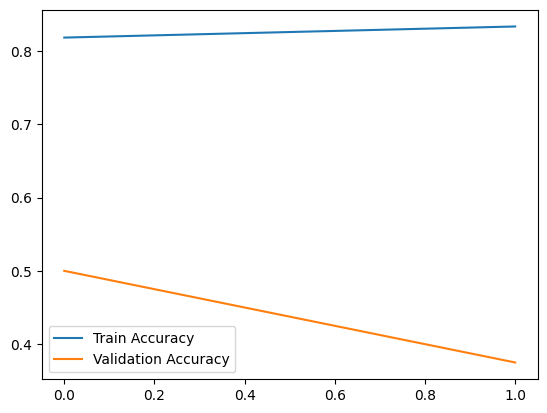

1/1 [==============================] - 15s 15s/step


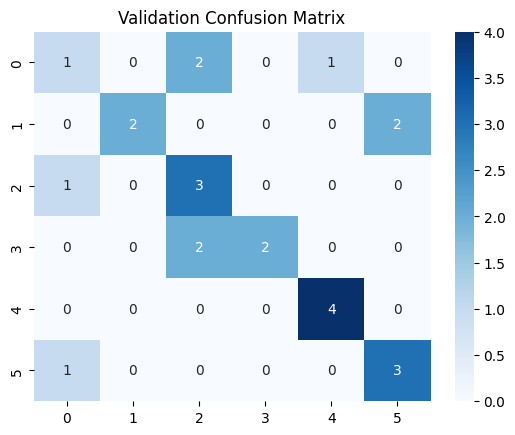

In [39]:
# Evaluate accuracy and loss graphs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Confusion matrix
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d')
plt.title("Validation Confusion Matrix")
plt.show()


In [40]:
# Classification report for validation set
val_classification_report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=words)
print("Validation Classification Report:")
print(val_classification_report)

# Final test evaluation
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

test_accuracy = np.mean(y_test_true_classes == y_test_pred_classes)
print(f"Test accuracy: {test_accuracy}")

# Test set classification report
test_classification_report = classification_report(y_test_true_classes, y_test_pred_classes, target_names=words)
print("Test Classification Report:")
print(test_classification_report)

Validation Classification Report:
              precision    recall  f1-score   support

       Begin       0.33      0.25      0.29         4
      Choose       1.00      0.50      0.67         4
        Next       0.43      0.75      0.55         4
       Start       1.00      0.50      0.67         4
        Stop       0.80      1.00      0.89         4
         Web       0.60      0.75      0.67         4

    accuracy                           0.62        24
   macro avg       0.69      0.62      0.62        24
weighted avg       0.69      0.62      0.62        24

1/1 [==============================] - 11s 11s/step
Test accuracy: 0.5833333333333334
Test Classification Report:
              precision    recall  f1-score   support

       Begin       0.75      0.75      0.75         4
      Choose       0.50      0.75      0.60         4
        Next       0.67      0.50      0.57         4
       Start       1.00      0.50      0.67         4
        Stop       0.57      1.00     

SAVING THE MODEL

In [41]:
# Save the model in Keras format
model_save_path = "lip_reading_model_effnet_final_58.33.keras"
model.save(model_save_path)
print(f"Model saved in Keras format to {model_save_path}")


Model saved in Keras format to lip_reading_model_effnet_final_58.33.keras


LOADING THE MODEL

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_save_path = "/content/lip_reading_model_effnet_final_58.33.keras"
new2 = load_model(model_save_path)
print("Model loaded successfully.")

y_test_pred = new2.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

test_accuracy = np.mean(y_test_true_classes == y_test_pred_classes)
print(f"Test Accuracy: {test_accuracy}")

test_classification_report = classification_report(y_test_true_classes, y_test_pred_classes, target_names=words)
print("Test Classification Report:")
print(test_classification_report)
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=words, yticklabels=words)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()